# Homework 4 - Ivan Aguilar

<img src="problem16.png">


In [70]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm

from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [86]:
# Auxiliary functions
def generate_data(n, d):
    identitym = np.identity(d)
    diagonalm = [1/(x+1) for x in range(d)]
    diagonalm = diagonalm*identitym

    meanz = [0]*d

    data = np.empty([n,d])
    y = np.empty([n,1])

    columns = ['x'+str(x) for x in range(1,d+1)]
    for x in range(n):
        data[x] = np.random.multivariate_normal(meanz,diagonalm,1)
        y[x] = data[x].sum() + np.random.normal(0,1)
        
    return data, y, columns

def get_data(n, d, exps, optim, step_type, step_value):
    s_mse = 0
    s_w = 0
    s_duration = 0
    for i in range(exps):
        data_np, y, columns = generate_data(n, d)
 
        data = pd.DataFrame(data_np)
        y = pd.DataFrame(y)
        data = pd.concat([data, y], axis=1)
        data.columns = columns + ['y']

        # run optimization
        x = np.array(data.drop('y', axis=1))
        y = np.array(data['y'])
        if optim == 'ols':
            optimizer = linear_model.LinearRegression(fit_intercept=False)
            mse, w, duration = run_ols(x, y, optimizer)
        elif optim == 'gd':  
            mse, w, duration = run_gd(x, y, d, n, step_type)
        elif optim == 'sgd':
            if step_type == 'constant':
                optimizer = linear_model.SGDRegressor(fit_intercept=False, eta0=0.1, learning_rate='constant', average=True, tol=None, max_iter=n)
            elif step_type == 'decreasing':
                optimizer = linear_model.SGDRegressor(fit_intercept=False, eta0=1, power_t=0.5, learning_rate='invscaling', average=True, tol=None, max_iter=n)        
            mse, w, duration = run_sgd(x, y, optimizer, d)

        s_mse = s_mse + mse
        s_w = s_w + w
        s_duration += duration
    
    return data, s_mse/exps, s_w/exps, s_duration/exps

def run_ols(x, y, optimizer):
    start_time = dt.datetime.now()
    opt = optimizer
    opt.fit(x, y)
    ypred = opt.predict(x)
    #mse = mean_squared_error(y, ypred)
    mse = get_mse(y,ypred)
    end_time = dt.datetime.now()
    duration = (end_time - start_time).microseconds
    return mse, opt.coef_, duration

def run_gd(x,y, d, iters, step_type):
    start_time = dt.datetime.now()
    mse = list()
    w = np.zeros(d)
    for i in range(iters):
        if step_type=='decreasing':
            lr = 1/np.sqrt(i)
        elif step_type=='constant':
            lr = 0.1
        prediction = np.dot(x,w.T)   
        w = w - (lr/len(y)) * np.dot(prediction - y,x)
        #mse.append(mean_squared_error(y, prediction))
        mse = get_mse(y, prediction)
    end_time = dt.datetime.now()
    duration = (end_time - start_time).microseconds
    return np.average(mse), w, duration


def run_sgd(x, y, optimizer, d):
    start_time = dt.datetime.now()
    opt = optimizer
    opt.fit(x, y, coef_init=np.zeros(d))
    ypred = opt.predict(x)
    #mse = mean_squared_error(y, ypred)
    mse = get_mse(y,ypred)
    end_time = dt.datetime.now()
    duration = (end_time - start_time).microseconds
    return mse, opt.coef_, duration


def get_mse(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    differences = np.subtract(actual, predicted)
    squared_differences = np.square(differences)
    return squared_differences.mean()



## Setup and parameters
Our data was generated as follows:

- x = multinomial with mean zero and covariance matrix 1/sqrt(d)

- y = sum of all elements x per observation + epsilon

- epsilon = standard normal

In our exercise we will set the below parameters and the will be used for the following combinations:

1- OLS regression

2- Gradient descent with fixed step size = 0.1

3- Gradient descent with decreasing fixed step = 1/sqrt(t)

4- Stochastic Gradient descent with fixed step size = 0.1

5- Stochastic Gradient descent with decreasing fixed step = 1/sqrt(t)

Each case will be executed through a total of 25 independent experiments and results are averaged


In [87]:
# set parameters
d = [5, 10, 20, 50]
n = [100, 200, 300, 400, 500]

exps = 25

In [88]:
# run iterations
results = pd.DataFrame()

for dimension in tqdm(d):
    for sample_size in n:
        # OLS
        data, mse, w, duration  = get_data(sample_size, dimension, exps, 'ols', 'none',0)
        temp = pd.DataFrame()
        temp['predictor'],temp['mse'], temp['w'], temp['duration'], temp['n'], temp['d'], temp['step_type'], temp['step_size'] = zip(['OLS',mse, w, duration,sample_size,dimension,'none', 0])
        results = results.append(temp)
        #GD fixed
        step_value = 0.1
        data, mse, w, duration  = get_data(sample_size, dimension, exps, 'gd', 'constant', step_value)
        temp = pd.DataFrame()
        temp['predictor'],temp['mse'], temp['w'], temp['duration'], temp['n'], temp['d'], temp['step_type'], temp['step_size'] = zip(['GD_fixed',mse, w, duration,sample_size,dimension,'constant',step_value])
        results = results.append(temp)
        #GD decreasing
        step_value = 1
        data, mse, w, duration  = get_data(sample_size, dimension, exps, 'gd', 'constant', step_value)
        temp = pd.DataFrame()
        temp['predictor'],temp['mse'], temp['w'], temp['duration'], temp['n'], temp['d'], temp['step_type'], temp['step_size'] = zip(['GD_decreasing',mse, w, duration,sample_size,dimension,'constant',step_value])
        results = results.append(temp)
        #SGD fixed
        data, mse, w, duration  = get_data(sample_size, dimension, exps, 'sgd', 'constant', step_value)
        temp = pd.DataFrame()
        temp['predictor'],temp['mse'], temp['w'], temp['duration'], temp['n'], temp['d'], temp['step_type'], temp['step_size'] = zip(['SGD_fixed',mse, w, duration,sample_size,dimension,'constant',step_value])
        results = results.append(temp)
        #SGD decreasing
        step_value = 1
        data, mse, w, duration  = get_data(sample_size, dimension, exps, 'sgd', 'decreasing', step_value)
        temp = pd.DataFrame()
        temp['predictor'],temp['mse'], temp['w'], temp['duration'], temp['n'], temp['d'], temp['step_type'], temp['step_size'] = zip(['SGD_decreasing',mse, w, duration,sample_size,dimension,'decreasing',step_value])
        results = results.append(temp)

results = results.reset_index()
results.shape

100%|██████████| 4/4 [02:45<00:00, 41.32s/it]


(100, 9)

## Findings

In terms of duration OLS is the fastest, followed by SGD and the slowest is GD. In all cases the more dimensions we use, the more time it takes to complete the preiction. And in all cases durations grow somehow linearly as sample size increases.

In terms of MSE they are all very similar, coming closer to 1 as per the error(epsilon) we have set, with some specific details that we will outline below.

<b>OLS</b>

This is the fastest predictor by far. Duration remains stable, but when reaching 50 dimensions it increases quite a lot, with goes with accordance with the process of inverting a large dimension. In terms of MSE it increasingly approaches the set epsilon (norm(0,1)) as we increase the sample size.

<b>GD</b>

This is the slowest predictor of all, which makes sense compared to SGD as it runs for the complete dataset (not in mini-batches). In terms of MSE it decreases approaching 1 (epsilon) as the sample size increases and the MSE is also notably disperse (higher for higher dimensions) only while the sample size is small. As the sample size increases all MSE are equal. Between the fixed step size and the decreasing step size versions, there are barely any differences, both perform equally in terms of MSE and duration.

<b>SGD</b>

The stochastic GD is considerable faster than GD, and duration increases consistently while increasing either sample size or dimensions. In terms of MSE it approaches epsilon as the sample size is increased. The only difference appreciated between the fixed and decreasing step size versions is that in higher dimensions the aproximation to epsilon is done earlier for the fixed step size version, which makes sense as steps are larger for each iteration for the fixed version.

Overall one notorious difference between the 5 variations is that OLS and SGD approach our epsilon in an increasing manner from low to high sample size. In the opposite side,  the GD approaches decreasingly when sample size moves from lower to higher values.



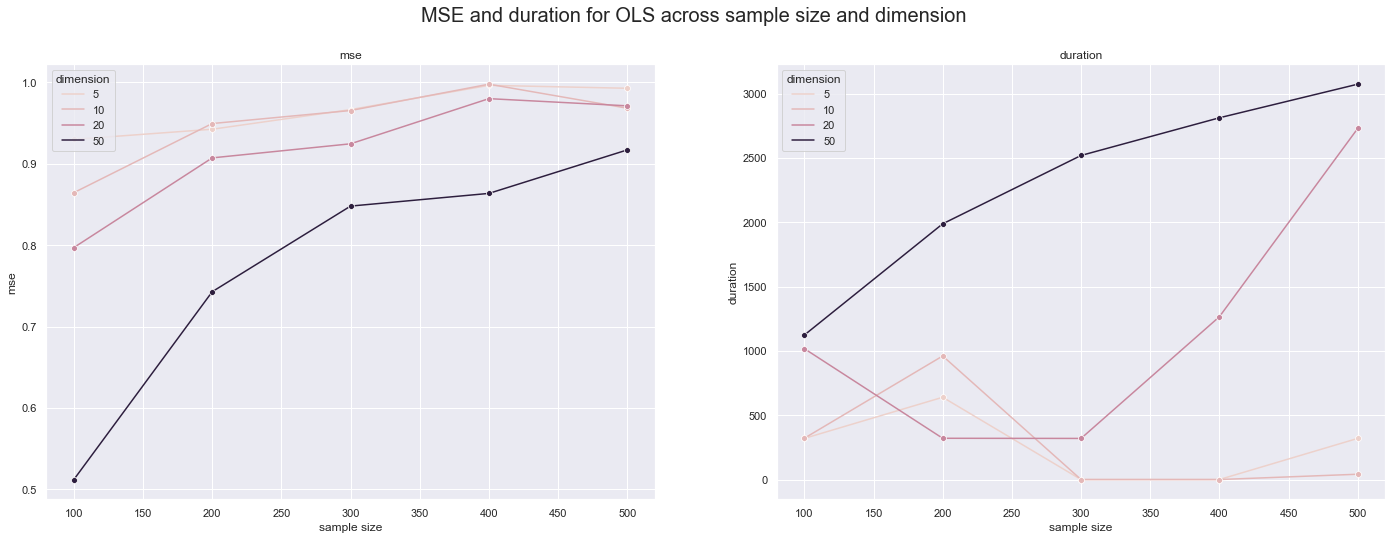

In [89]:
sns.set(style="darkgrid")
fig1, ax1 = plt.subplots(1, 2, figsize=(24,8))
#figure(figsize=(8, 6), dpi=80)
palette = sns.set_palette('rocket')

graph_results = results[results.predictor == 'OLS']

fig1.suptitle('MSE and duration for OLS across sample size and dimension', size=20)
ax1[0].set_title(label = 'mse')
ax1[1].set_title(label = 'duration')
p1 = sns.lineplot(data=graph_results, ax=ax1[0], y='mse', x='n', hue='d',  marker = 'o');
p2 = sns.lineplot(data=graph_results, ax=ax1[1], y='duration', x='n', hue='d',  marker = 'o');
p1.set_xlabel('sample size')
p2.set_xlabel('sample size')
p1.legend(title='dimension',loc='upper left');
p2.legend(title='dimension',loc='upper left');


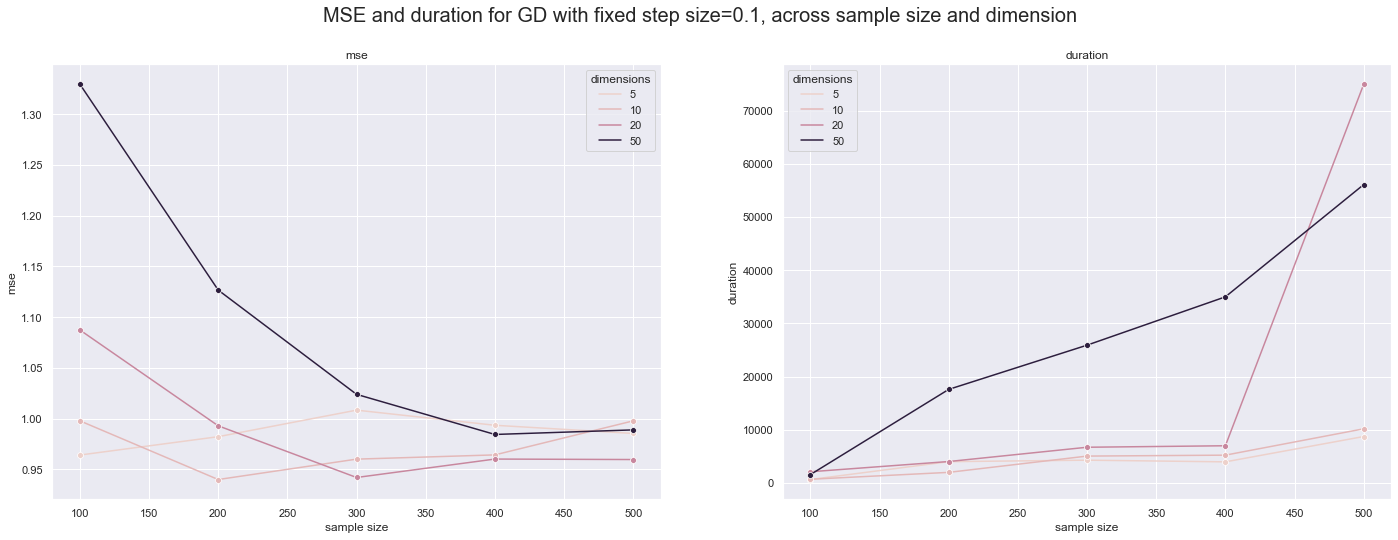

<Figure size 640x480 with 0 Axes>

In [90]:
sns.set(style="darkgrid")
fig1, ax1 = plt.subplots(1, 2, figsize=(24,8))
figure(figsize=(8, 6), dpi=80)
palette = sns.set_palette('rocket')

graph_results = results[results.predictor == 'GD_fixed']

fig1.suptitle('MSE and duration for GD with fixed step size=0.1, across sample size and dimension', size=20)
ax1[0].set_title(label = 'mse')
ax1[1].set_title(label = 'duration')
p1 = sns.lineplot(data=graph_results, ax=ax1[0], y='mse', x='n', hue='d',  marker = 'o');
p2 = sns.lineplot(data=graph_results, ax=ax1[1], y='duration', x='n', hue='d',  marker = 'o');
p1.set_xlabel("sample size")
p2.set_xlabel("sample size")
p1.legend(title='dimensions',loc='upper right');
p2.legend(title='dimensions',loc='upper left');

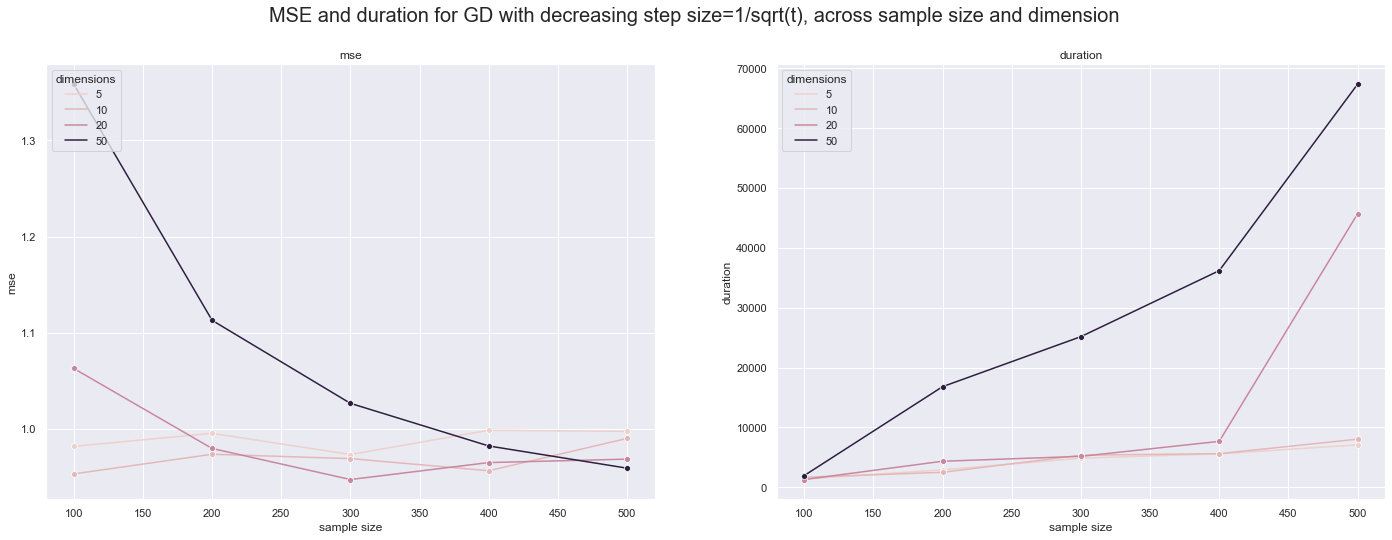

<Figure size 640x480 with 0 Axes>

In [91]:
sns.set(style="darkgrid")
fig1, ax1 = plt.subplots(1, 2, figsize=(24,8))
figure(figsize=(8, 6), dpi=80)
palette = sns.set_palette('rocket')

graph_results = results[results.predictor == 'GD_decreasing']

fig1.suptitle('MSE and duration for GD with decreasing step size=1/sqrt(t), across sample size and dimension', size=20)
ax1[0].set_title(label = 'mse')
ax1[1].set_title(label = 'duration')
p1 = sns.lineplot(data=graph_results, ax=ax1[0], y='mse', x='n', hue='d',  marker = 'o');
p2 = sns.lineplot(data=graph_results, ax=ax1[1], y='duration', x='n', hue='d',  marker = 'o');
p1.set_xlabel('sample size')
p2.set_xlabel('sample size')
p1.legend(title='dimensions',loc='upper left');
p2.legend(title='dimensions',loc='upper left');

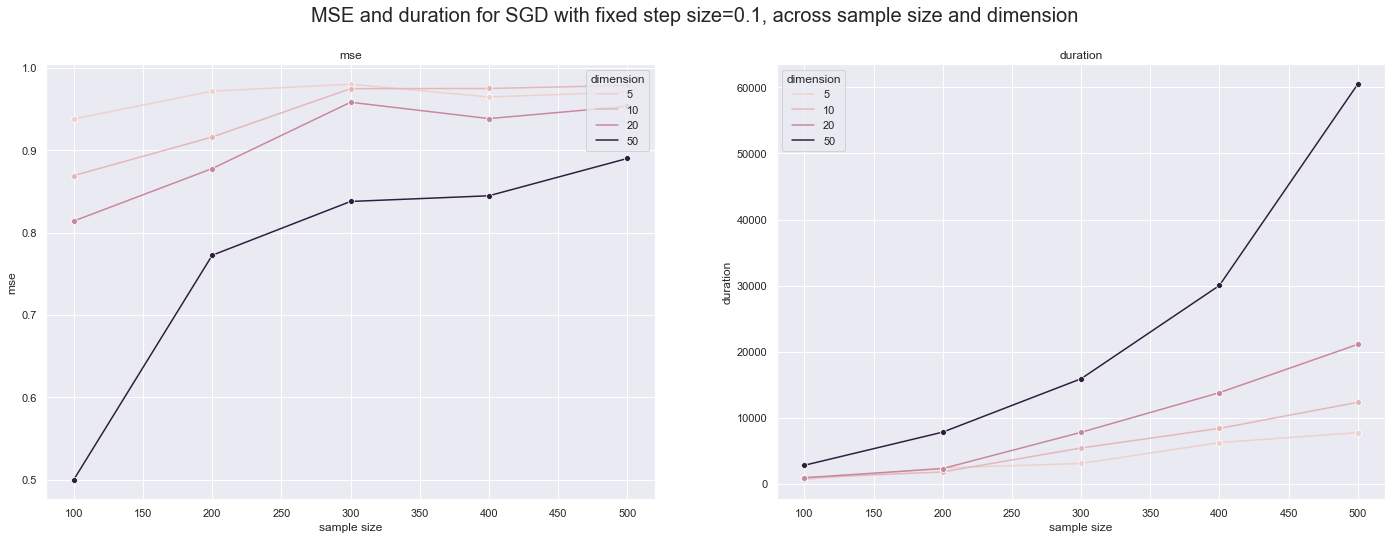

In [92]:
sns.set(style="darkgrid")
fig1, ax1 = plt.subplots(1, 2, figsize=(24,8))
# figure(figsize=(8, 6), dpi=80)
palette = sns.set_palette('rocket')

graph_results = results[results.predictor == 'SGD_fixed']

fig1.suptitle('MSE and duration for SGD with fixed step size=0.1, across sample size and dimension', size=20)
ax1[0].set_title(label = 'mse')
ax1[1].set_title(label = 'duration')
p1 = sns.lineplot(data=graph_results, ax=ax1[0], y='mse', x='n', hue='d',  marker = 'o');
p2 = sns.lineplot(data=graph_results, ax=ax1[1], y='duration', x='n', hue='d',  marker = 'o');
p1.set_xlabel('sample size')
p2.set_xlabel('sample size')
p1.legend(title='dimension',loc='upper right');
p2.legend(title='dimension',loc='upper left');


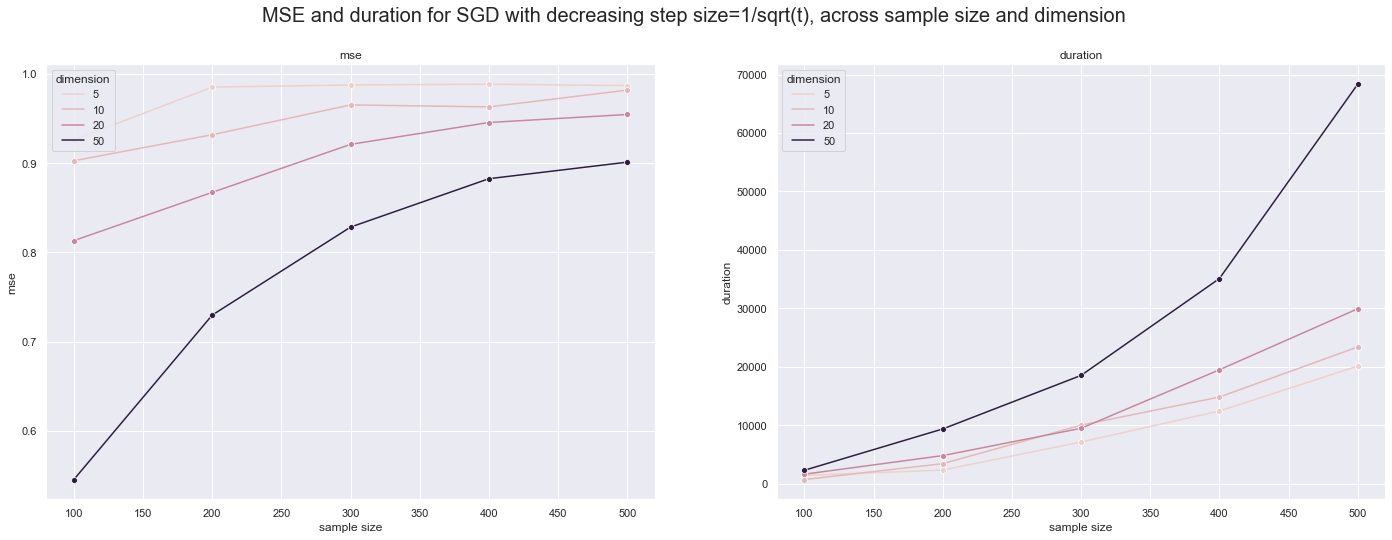

<Figure size 640x480 with 0 Axes>

In [93]:
sns.set(style="darkgrid")
fig1, ax1 = plt.subplots(1, 2, figsize=(24,8))
figure(figsize=(8, 6), dpi=80)
palette = sns.set_palette('rocket')

graph_results = results[results.predictor == 'SGD_decreasing']

fig1.suptitle('MSE and duration for SGD with decreasing step size=1/sqrt(t), across sample size and dimension', size=20)
ax1[0].set_title(label = 'mse')
ax1[1].set_title(label = 'duration')
p1 = sns.lineplot(data=graph_results, ax=ax1[0], y='mse', x='n', hue='d',  marker = 'o');
p2 = sns.lineplot(data=graph_results, ax=ax1[1], y='duration', x='n', hue='d',  marker = 'o');
p1.set_xlabel('sample size')
p2.set_xlabel('sample size')
p1.legend(title='dimension',loc='upper left');
p2.legend(title='dimension',loc='upper left');
